In [26]:
import os
import random
import copy
import time
from pathlib import Path


import numpy as np
from tqdm import tqdm


import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models


from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt

In [27]:
# ---------------------------
# Config
# ---------------------------
DATA_DIR = "Dataset" # change if needed
BATCH_SIZE = 32
NUM_EPOCHS = 20
LR = 1e-3
WEIGHT_DECAY = 1e-4
IMAGE_SIZE = 224
NUM_WORKERS = 4
PIN_MEMORY = True
RANDOM_SEED = 42
BEST_MODEL_PATH = "best_resnet18_materials.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# fix seeds for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

In [28]:


# ---------------------------
# Transforms (augmentation + preprocessing)
# ---------------------------
train_transforms = transforms.Compose([
transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
transforms.RandomHorizontalFlip(p=0.5),
transforms.RandomApply([transforms.ColorJitter(0.3, 0.3, 0.2, 0.1)], p=0.5),
transforms.RandomRotation(10),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


val_transforms = transforms.Compose([
transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [29]:
# ---------------------------
# Dataset & Dataloaders
# ---------------------------
if not os.path.isdir(DATA_DIR):
    raise FileNotFoundError(f"Dataset folder not found at {DATA_DIR}. Update DATA_DIR variable.")


full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transforms)
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Found classes: {class_names} (n={num_classes})")


# Split dataset into train / val (80/20)
num_images = len(full_dataset)
val_pct = 0.2
val_size = int(num_images * val_pct)
train_size = num_images - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(RANDOM_SEED))

Found classes: ['e-waste', 'fabric', 'metal', 'paper', 'plastic'] (n=5)


In [30]:
# Important: the validation dataset should use val_transforms
# random_split returns Subset wrappers; we need to replace the transform
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)


print(f"Train images: {len(train_dataset)}, Val images: {len(val_dataset)}")

Train images: 8818, Val images: 2204


In [31]:
# ---------------------------
# Model - ResNet18 Transfer Learning
# ---------------------------
model = models.resnet18(pretrained=True)
# Freeze the base parameters (optional for faster convergence)
for param in model.parameters():
    param.requires_grad = False


# Replace the final fully-connected layer
in_features = model.fc.in_features
model.fc = nn.Sequential(
nn.Linear(in_features, 256),
nn.ReLU(inplace=True),
nn.Dropout(0.4),
nn.Linear(256, num_classes)
)

In [32]:
# Unfreeze the final fc layer parameters
for param in model.fc.parameters():
    param.requires_grad = True


model = model.to(DEVICE)

In [33]:
# Loss, optimizer, scheduler
# If class imbalance exists, you can compute class weights and pass to CrossEntropyLoss
# Example (commented):
# from collections import Counter
# counts = Counter([s[1] for s in full_dataset.samples])
# weights = [1.0/counts[i] for i in range(num_classes)]
# class_weights = torch.FloatTensor(weights).to(DEVICE)
# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [37]:
# ---------------------------
# Training & Validation loops
# ---------------------------


def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    preds_all = []
    labels_all = []


    for images, labels in tqdm(dataloader, desc="Train", leave=False):
        images = images.to(device)
        labels = labels.to(device)


        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1).detach().cpu().numpy()
        labels_cpu = labels.detach().cpu().numpy()
        preds_all.extend(preds.tolist())
        labels_all.extend(labels_cpu.tolist())


    epoch_loss = running_loss / len(dataloader.dataset)
    acc = accuracy_score(labels_all, preds_all)
    return epoch_loss, acc


In [38]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    preds_all = []
    labels_all = []


    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Val", leave=False):
            images = images.to(device)
            labels = labels.to(device)


            outputs = model(images)
            loss = criterion(outputs, labels)


            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1).detach().cpu().numpy()
            labels_cpu = labels.detach().cpu().numpy()
            preds_all.extend(preds.tolist())
            labels_all.extend(labels_cpu.tolist())


    epoch_loss = running_loss / len(dataloader.dataset)
    acc = accuracy_score(labels_all, preds_all)
    precision, recall, f1, _ = precision_recall_fscore_support(labels_all, preds_all, average='macro', zero_division=0)
    cm = confusion_matrix(labels_all, preds_all)
    return epoch_loss, acc, precision, recall, f1, cm, labels_all, preds_all

best_val_acc = 0.0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "val_precision": [], "val_recall": [], "val_f1": []}


start_time = time.time()
for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch {epoch}/{NUM_EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc, val_precision, val_recall, val_f1, cm, val_labels, val_preds = evaluate(model, val_loader, criterion, DEVICE)


    scheduler.step()


    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_precision"].append(val_precision)
    history["val_recall"].append(val_recall)
    history["val_f1"].append(val_f1)


    print(f" Train loss: {train_loss:.4f} acc: {train_acc:.4f}")
    print(f" Val loss: {val_loss:.4f} acc: {val_acc:.4f} precision: {val_precision:.4f} recall: {val_recall:.4f} f1: {val_f1:.4f}")

Epoch 1/20


 Train loss: 0.2520 acc: 0.9129
 Val loss: 0.1192 acc: 0.9587 precision: 0.9178 recall: 0.9036 f1: 0.9058
Epoch 2/20


 Train loss: 0.1378 acc: 0.9511
 Val loss: 0.0926 acc: 0.9664 precision: 0.9300 recall: 0.9202 f1: 0.9208
Epoch 3/20


 Train loss: 0.1166 acc: 0.9585
 Val loss: 0.0884 acc: 0.9691 precision: 0.9320 recall: 0.9293 f1: 0.9272
Epoch 4/20


 Train loss: 0.0981 acc: 0.9645
 Val loss: 0.0847 acc: 0.9723 precision: 0.9419 recall: 0.9342 f1: 0.9352
Epoch 5/20


 Train loss: 0.1003 acc: 0.9648
 Val loss: 0.0734 acc: 0.9769 precision: 0.9529 recall: 0.9450 f1: 0.9483
Epoch 6/20


 Train loss: 0.0896 acc: 0.9677
 Val loss: 0.0741 acc: 0.9741 precision: 0.9406 recall: 0.9454 f1: 0.9428
Epoch 7/20


 Train loss: 0.0892 acc: 0.9685
 Val loss: 0.0673 acc: 0.9782 precision: 0.9524 recall: 0.9495 f1: 0.9508
Epoch 8/20


 Train loss: 0.0635 acc: 0.9783
 Val loss: 0.0658 acc: 0.9796 precision: 0.9531 recall: 0.9554 f1: 0.9543
Epoch 9/20


 Train loss: 0.0573 acc: 0.9799
 Val loss: 0.0694 acc: 0.9809 precision: 0.9588 recall: 0.9539 f1: 0.9560
Epoch 10/20


 Train loss: 0.0555 acc: 0.9792
 Val loss: 0.0624 acc: 0.9819 precision: 0.9586 recall: 0.9585 f1: 0.9585
Epoch 11/20


 Train loss: 0.0531 acc: 0.9815
 Val loss: 0.0672 acc: 0.9787 precision: 0.9518 recall: 0.9496 f1: 0.9504
Epoch 12/20


 Train loss: 0.0566 acc: 0.9795
 Val loss: 0.0676 acc: 0.9764 precision: 0.9467 recall: 0.9460 f1: 0.9460
Epoch 13/20


 Train loss: 0.0484 acc: 0.9832
 Val loss: 0.0642 acc: 0.9787 precision: 0.9515 recall: 0.9506 f1: 0.9510
Epoch 14/20


 Train loss: 0.0508 acc: 0.9807
 Val loss: 0.0623 acc: 0.9805 precision: 0.9543 recall: 0.9560 f1: 0.9550
Epoch 15/20


 Train loss: 0.0492 acc: 0.9819
 Val loss: 0.0638 acc: 0.9796 precision: 0.9541 recall: 0.9522 f1: 0.9531
Epoch 16/20


 Train loss: 0.0460 acc: 0.9849
 Val loss: 0.0612 acc: 0.9823 precision: 0.9599 recall: 0.9588 f1: 0.9592
Epoch 17/20


 Train loss: 0.0489 acc: 0.9816
 Val loss: 0.0648 acc: 0.9796 precision: 0.9549 recall: 0.9525 f1: 0.9537
Epoch 18/20


 Train loss: 0.0519 acc: 0.9809
 Val loss: 0.0632 acc: 0.9805 precision: 0.9564 recall: 0.9561 f1: 0.9560
Epoch 19/20


 Train loss: 0.0457 acc: 0.9851
 Val loss: 0.0629 acc: 0.9787 precision: 0.9537 recall: 0.9499 f1: 0.9517
Epoch 20/20


 Train loss: 0.0434 acc: 0.9861
 Val loss: 0.0597 acc: 0.9809 precision: 0.9559 recall: 0.9559 f1: 0.9559


In [39]:
# save best
if val_acc > best_val_acc:
    best_val_acc = val_acc
    best_model_wts = copy.deepcopy(model.state_dict())
    torch.save({
        'model_state_dict': best_model_wts,
        'class_names': class_names,
        'epoch': epoch,
        'val_acc': best_val_acc
    }, BEST_MODEL_PATH)
    print(f" Saved best model to {BEST_MODEL_PATH}")


elapsed = time.time() - start_time
print(f"Training complete in {elapsed//60:.0f}m {elapsed%60:.0f}s. Best val acc: {best_val_acc:.4f}")

 Saved best model to best_resnet18_materials.pth
Training complete in 193m 40s. Best val acc: 0.9809


C:\Users\varun\AppData\Local\Temp\ipykernel_29248\199567226.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(BEST_MODEL_PATH, map_location=DEVICE)

Final evaluation on validation set:
 Accuracy: 0.9809
 Precision (macro): 0.9559
 Recall (macro): 0.9559
 F1 (macro): 0.9559
Saved confusion matrix to confusion_matrix.png


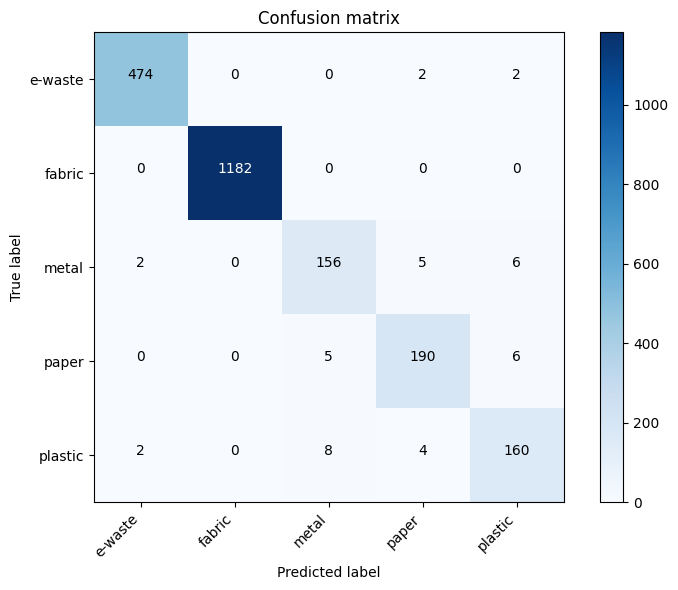

In [41]:
# ---------------------------
# Final evaluation & confusion matrix plot
# ---------------------------
# Load best model for final eval
if os.path.exists(BEST_MODEL_PATH):
    checkpoint = torch.load(BEST_MODEL_PATH, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])


model.eval()
_, final_acc, final_precision, final_recall, final_f1, cm, y_true, y_pred = evaluate(model, val_loader, criterion, DEVICE)


print("Final evaluation on validation set:")
print(f" Accuracy: {final_acc:.4f}")
print(f" Precision (macro): {final_precision:.4f}")
print(f" Recall (macro): {final_recall:.4f}")
print(f" F1 (macro): {final_f1:.4f}")


# plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)


thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")


plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', bbox_inches='tight')
print('Saved confusion matrix to confusion_matrix.png')

In [72]:
# ---------------------------
# Inference helper
# ---------------------------
from PIL import Image


def predict_image(image_path, model, transform, device):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(x)
        prob = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred_idx = int(out.argmax(dim=1).cpu().numpy()[0])
    return class_names[pred_idx], prob


# Example usage (uncomment and update path):
img_path = 'Dataset/fabric/fabric1.jpg'
pred_class, prob = predict_image(img_path, model, val_transforms, DEVICE)
print(f'Predicted: {pred_class}, confidences: {prob}')


print('Script finished.')

Predicted: fabric, confidences: [8.4367835e-10 9.9999976e-01 4.7294716e-08 7.6036237e-08 7.9640778e-08]
Script finished.


In [48]:
pip install onnx


^C
Note: you may need to restart the kernel to use updated packages.
  Using cached protobuf-6.32.1-cp310-abi3-win_amd64.whl.metadata (593 bytes)
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
    --------------------------------------- 0.3/16.5 MB ? eta -:--:--
   - -------------------------------------- 0.5/16.5 MB 1.4 MB/s eta 0:00:12
   - -------------------------------------- 0.8/16.5 MB 1.4 MB/s eta 0:00:12
   --- ------------------------------------ 1.3/16.5 MB 1.5 MB/s eta 0:00:11
   --- ------------------------------------ 1.6/16.5 MB 1.5 MB/s eta 0:00:10
   ---- ----------------------------------- 1.8/16.5 MB 1.4 MB/s eta 0:00:11
   ---- ----------------------------------- 1.8/16.5 MB 1.4 MB/s eta 0:00:11
   ---- ----------------------------------- 1.8/16.5 MB 1.4 MB/s eta 0:00:11
   ----- ---------------------------------- 2.1/16.5 MB 1.0 MB/s eta 0:00:15
   ----- -------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.41.1 requires protobuf<6,>=3.20, but you have protobuf 6.32.1 which is incompatible.
tensorflow-intel 2.18.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.32.1 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [57]:
pip install --upgrade ml-dtypes


  Using cached ml_dtypes-0.5.3-cp312-cp312-win_amd64.whl.metadata (9.2 kB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.3 which is incompatible.
tensorflow-intel 2.18.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.32.1 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [85]:
# ---------------------------
# Model Export (choose ONNX or TorchScript)
# ---------------------------

EXPORT_ONNX_PATH = "resnet18_materials.onnx"
EXPORT_TS_PATH = "resnet18_materials.pt"

# Export to TorchScript
dummy_input = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE, device=DEVICE)
traced_model = torch.jit.trace(model, dummy_input)
traced_model.save(EXPORT_TS_PATH)
print(f"TorchScript model saved to {EXPORT_TS_PATH}")

# Export to ONNX
try:
    torch.onnx.export(
        model,
        dummy_input,
        EXPORT_ONNX_PATH,
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={"input": {0: "batch"}, "output": {0: "batch"}},
        opset_version=11,  # Use 11 instead of 14 for better compatibility
        export_params=True,
        do_constant_folding=True,
    )
    print(f"✓ ONNX model saved to {EXPORT_ONNX_PATH}")
except Exception as e:
    print(f"✗ ONNX export failed: {e}")


TorchScript model saved to resnet18_materials.pt
✗ ONNX export failed: module 'ml_dtypes' has no attribute 'float4_e2m1fn'


In [86]:
# ---------------------------
# Model Export (TorchScript - More Reliable)
# ---------------------------
print("\n=== Exporting Model ===")

EXPORT_TS_PATH = "resnet18_materials.pt"

# Ensure model is in eval mode
model.eval()
dummy_input = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE, device=DEVICE)

# Export to TorchScript
try:
    traced_model = torch.jit.trace(model, dummy_input)
    traced_model.save(EXPORT_TS_PATH)
    print(f"✓ TorchScript model saved to {EXPORT_TS_PATH}")
    
    # Save class names and metadata
    import json
    metadata = {
        "class_names": class_names,
        "image_size": IMAGE_SIZE,
        "num_classes": num_classes,
        "model": "resnet18",
        "best_val_acc": float(best_val_acc)
    }
    with open("model_metadata.json", "w") as f:
        json.dump(metadata, f, indent=2)
    print(f"✓ Metadata saved to model_metadata.json")
    
except Exception as e:
    print(f"✗ TorchScript export failed: {e}")

# Optional: Try ONNX export (gracefully fail if issues)
print("\nAttempting ONNX export (optional)...")
try:
    EXPORT_ONNX_PATH = "resnet18_materials.onnx"
    torch.onnx.export(
        model,
        dummy_input,
        EXPORT_ONNX_PATH,
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={"input": {0: "batch"}, "output": {0: "batch"}},
        opset_version=11,
        export_params=True,
        do_constant_folding=True,
    )
    print(f"✓ ONNX model saved to {EXPORT_ONNX_PATH}")
except Exception as e:
    print(f"⚠ ONNX export failed (TorchScript is sufficient): {e}")


=== Exporting Model ===
✓ TorchScript model saved to resnet18_materials.pt
✓ Metadata saved to model_metadata.json

Attempting ONNX export (optional)...
⚠ ONNX export failed (TorchScript is sufficient): module 'ml_dtypes' has no attribute 'float4_e2m1fn'


In [89]:
import torch

from torchvision import transforms
from PIL import Image
import numpy as np

IMAGE_SIZE = 224
class_names = ["#e-waste", "#fabric", "#metal", "#paper", "#plastic"]  # same order as training

# Preprocessing
val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

def predict_torchscript(img_path, model_path="resnet18_materials.pt"):
    model = torch.jit.load(model_path, map_location="cpu")
    model.eval()
    img = Image.open(img_path).convert("RGB")
    x = val_transforms(img).unsqueeze(0)
    with torch.no_grad():
        out = model(x)
        probs = torch.softmax(out, dim=1)[0].numpy()
        pred_idx = int(probs.argmax())
    return class_names[pred_idx], float(probs[pred_idx])



# Example usage
if __name__ == "__main__":
    img_path = "Dataset/fabric/fabric1.jpg"

    pred, conf = predict_torchscript(img_path)
    print(f"[TorchScript] Predicted: {pred}, Confidence: {conf:.4f}")

   

[TorchScript] Predicted: #fabric, Confidence: 1.0000
